In [1]:
import functions as mf
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


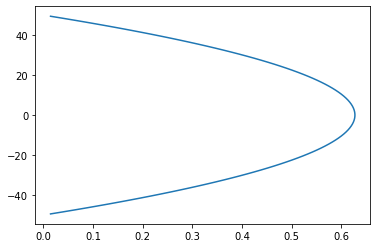

In [19]:
# Define the grid
Ny = 100
y_end = 100

# Define flow parameters
rho = 1000
mu_0 = 1
pressure_difference = 1 * mu_0 / rho
pressure_boundary = np.array([4, 4]) * mu_0 / rho
boundary_condition = [1, 1] 

# Set the system up
system = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
mu = system.calc_mu(mu_0)
velocity_laminar = system.simulate(mu)
plt.plot(velocity_laminar[1:-1], system.y[1:-1])
plt.show()

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


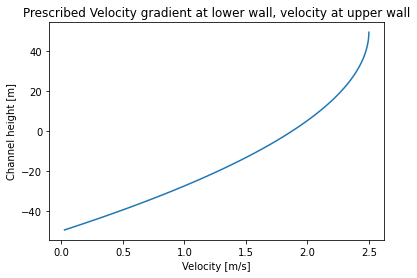

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


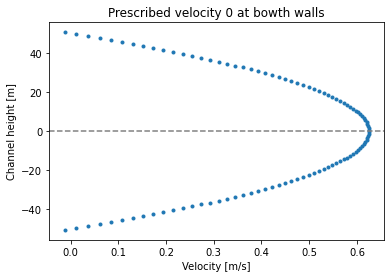

prescribed shear stress at wall


C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


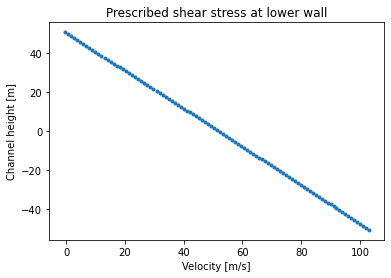

In [17]:
# velocity gradient is 0 at wall 1, velocity set at wall 2
boundary_condition = [1,-1]
pressure_boundary = [0, 0]
system_velocity_gradient = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
solution = system_velocity_gradient.simulate(mu)
plt.plot(solution[1:-1], system_velocity_gradient.y[1:-1])
plt.title("Prescribed Velocity gradient at lower wall, velocity at upper wall")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.show()

# velocity is 0 at wall
boundary_condition = [1, 1]
system_velocity_zero = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
solution = system_velocity_zero.simulate(mu)
plt.title("Prescribed velocity 0 at bowth walls")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.plot(solution,system_velocity_zero.y, '.')
plt.axhline(0, color='grey', linestyle='dashed')
plt.show()

# prescribed shear stress at wall
print("prescribed shear stress at wall")
stress = 1
boundary_condition = [-1, 1]
pressure_boundary = [-stress * (y_end / Ny) / mu[0], 0]
system_velocity_shear_stress = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
solution = system_velocity_shear_stress.simulate(mu)
plt.title("Prescribed shear stress at lower wall")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.plot(solution,system_velocity_shear_stress.y, '.')
plt.show()


prantl mixing length

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Oh nyo, it's bwoken error 14.813210185484147th error 14.81321018545710718.098428033716154 18.098428033812564 395 with error 14.81321018546069 487 with error 14.813210185452057 578 with error 18.098428033716772 669 with error 14.813210185499884 with error 14.813210185428964 919 with error 14.813210185452538 1100 with error 18.098428033765362 1189 with error 14.813210185462177 1277 with error 14.813210185459123 with error 14.813210185468673 1420 with error 18.098428033777463 1468 with error 18.098428033731707 1521 with error 14.813210185479848with error 18.098428033722517 1789 with error 14.813210185447842 1847 with error 14.813210185453075 with error 14.813210185408748 1973 with error 14.81321018543619


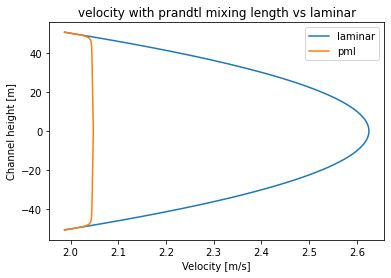

In [18]:
argument_type = "Spalding"

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar, system.y, label="laminar")
plt.plot(velocity_new, system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()


wall functions

65.61218269244945
5teration 5 with error nan666241933488358e+109


C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
<ipython-input-15-aa1bbef65a17>:31: RuntimeWarning: overflow encountered in double_scalars
  tau_w = rho * u_tau**2
C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


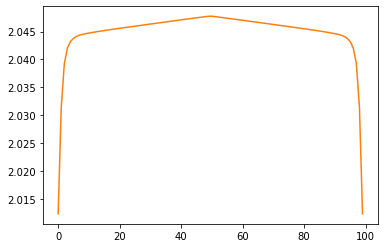

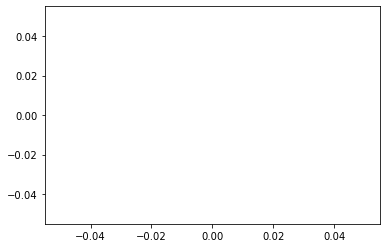

In [15]:
# Define constants
kappa = 0.41
E = 9.8
nu = mu_turbulent / rho
B = 5.0

# Velocity profile
velocity_new = velocity_turbulent

# First round of calculating variables
u_1 = velocity_new[1]
lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu[1]))
u_tau = kappa * u_1 / lamberts_factor
y_plus = system.y_wall * u_tau / nu
print(y_plus[1])

# Define reference tau_w
tau_ref = system.pressure_difference[0] * y_end / 2

error  = 10
epsilon = 1e-7
i=0
while error > epsilon:
  velocity_old = velocity_new
  # Calculate new constant with u_tau != u_1 in log
  u_1 = velocity_new[1]
  lamberts_factor = abs(lambertw(u_1 * system.y_wall[1] * kappa * np.exp(kappa * B ) / nu[1]))
  u_tau = kappa * u_1 / lamberts_factor

  # Calculate tau_w and new constant
  tau_w = rho * u_tau**2
  C = tau_w / u_1

  # Velocity shouldn't change on u_1
  velocity_new = system.simulate_wallfunctions(mu_turbulent, C, tau_w)
  
  error = np.abs(np.sum(velocity_new - velocity_old) / np.sum(velocity_old))
  i+=1
  print("iteration", i, "with error", error, end='\r')

print(i)
plt.plot(velocity_new[1:-1])
plt.plot(velocity_turbulent[1:-1])
plt.show()
plt.plot(velocity_new - velocity_turbulent)

In [10]:
print(tau_w, tau_ref)
print(y_plus)

0.050539456914852565 100.0
[-2.02909897  2.04176265  3.12175068  2.52910441  2.19111586  1.98065247
  1.85043877  1.76870688  1.71781551  1.69055097  1.66208266  1.74396713
  1.92556636  2.09853151  2.28240297  2.47347968  2.67243398  2.87922515
  3.09404211  3.3171373   3.54886221  3.78966603  4.04010173  4.30083262
  4.57264142  4.85644238  5.15329738  5.46443697  5.79128769  6.13550727
  6.49902998  6.88412525  7.29347391  7.73026811  8.198344    8.70236005
  9.24804104  9.84251767 10.49481008 11.21653306 12.02295481 12.93464037
 13.9801069  15.20031895 16.65679329 18.44708015 20.73931834 23.84355739
 28.53493873 36.2032356  70.22658357 70.22658357 36.2032356  28.53493873
 23.84355739 20.73931834 18.44708015 16.65679329 15.20031895 13.9801069
 12.93464037 12.02295481 11.21653306 10.49481008  9.84251767  9.24804104
  8.70236005  8.198344    7.73026811  7.29347391  6.88412525  6.49902998
  6.13550727  5.79128769  5.46443697  5.15329738  4.85644238  4.57264142
  4.30083262  4.04010173 

Euler-Euler